In [428]:
import sys
import os
import pandas as pd
import chess
import chess.svg
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from ast import literal_eval
import numpy as np


In [429]:
# set the parameters for plotting
rcParams['font.family'] = 'monospace'
plt.style.use("bmh")


In [431]:
df = pd.read_csv(os.getcwd() + '\\data.csv')

In [416]:
df.loc[:, 'game'] = df.loc[:, 'game'].apply(lambda x : x.replace("..", ""))

In [417]:
def retrieve_board(moves, display = False):
    """
    Given a sequence of moves in Standard Algebraic Notation, obtain a board representing the
    configuration reached after these moves.
    
    Parameters
    ----------
    moves : string
        encodes a succession of chess moves in Standard Algebraic Notation
    
    display : bool, default = False
        if True, show the board in graphical format

    Returns
    ---------
    board : chess Board
        represents the configuration reached after the executed moves
    """

    # initialize the board
    board = chess.Board()
    
    # execute the moves sequentially
    moves_list = moves.split()
    final_moves = [x.split('.')[-1] for x in moves_list]

    for m in final_moves:
        board.push_san(m)

    # only show the configuration when specifically asked to
    if display:
        display(board)

    return board

In [418]:
def identify_piece_moved_wrongly(moves, faulty_move, return_symbol = False):
    """
    Identify if the faulty move is due to an attempt to incorrectly move a piece.
    Whenever this is the case, identify the wrongly moved piece.

    The following notations are used to encode pieces:

    pawn -- 1
    knight -- 2
    bishop -- 3
    rook -- 4
    queen -- 5
    king -- 6

    Parameters
    ----------
    moves : string
        encodes a succession of chess moves in Standard Algebraic Notation
    faulty_move : string
        the illegal move selected by ChatGPT that determined the game to break
    """

    # set up the board
    board = retrieve_board(moves)

    # the type of a piece is the first character of a move in the Standard Algebraic Notation
    # note that a pawn is not signaled by a specific letter but we can check that since the symbol
    # the symbol for any other piece is uppercase
    piece_symbol = faulty_move[0]

    if piece_symbol.isupper():

        if piece_symbol in ['B', 'N', 'R', 'Q', 'K']:

                if return_symbol:

                    if piece_symbol == 'B':
                        piece = "Bishop"

                    if piece_symbol == 'N':
                        piece = 'Knight'

                    if piece_symbol == 'R':
                        piece = 'Rook'

                    if piece_symbol == 'Q':
                        piece = 'Queen'

                    if piece_symbol == "K":
                        piece = "King"

                else:
                    piece = chess.Piece.from_symbol(piece_symbol)
            
        else:
            piece = 'None'

    else:
        # when no symbol is present, the piece must be a pawn
        piece = 'Pawn' if return_symbol else chess.Piece.from_symbol('P')

    
    return piece

In [419]:
pieces_moved_wrongly = []

for moves, faulty_move in zip(list(df['game']), list(df['faulty_move'])):
    
    piece = identify_piece_moved_wrongly(moves, faulty_move, return_symbol = True)
    
    if piece != 'None':
        pieces_moved_wrongly.append(piece)

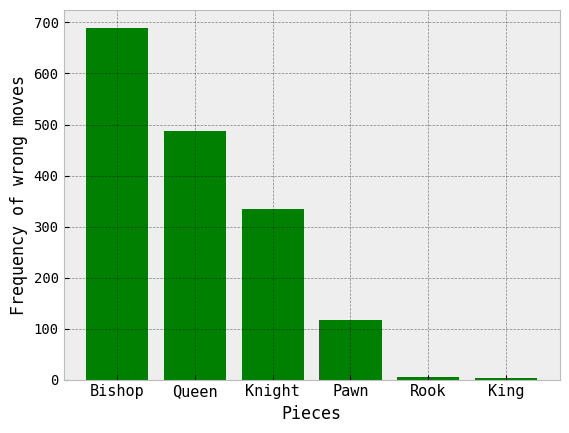

In [420]:
a = dict(Counter(pieces_moved_wrongly))
ind = np.argsort(list(a.values()))[::-1]

bars = list(a.keys())
heights = np.array(list(a.values()))[ind]

plt.bar(bars, heights, color = 'g')
plt.grid(alpha = 0.45, linestyle = "--", color = 'black')

plt.xlabel("Pieces")
plt.ylabel("Frequency of wrong moves")
plt.xticks(fontsize =11)
plt.show()

In [425]:
(df['number of moves'] > 10).mean()

0.05090909090909091

In [352]:
def identify_nature_of_captured_piece(moves, faulty_move, display_board = True):
    """
    Given a sequence of moves, as well as a move that led to the termination of the game,
    classify this move in : captured an enemy piece, captured own piece, captured imaginary piece.

    Parameters
    ----------
    moves : string
        encodes a succession of chess moves in Standard Algebraic Notation
    faulty_move : string
        the illegal move selected by ChatGPT that determined the game to break
    """

    board = retrieve_board(moves)

    if display_board:
        display(board)

    if faulty_move[1] != 'x':
    
        return 'None'

    else:

        # this is the square where ChatGPT decided to move the piece
        attacked_square = faulty_move[2:4]

        # trasform into a chess Square object
        sq = chess.parse_square(attacked_square)

        # check if there is a piece on this square
        piece_on_target_square = board.piece_type_at(sq)
        piece_color_on_target_square = board.color_at(sq)

        if piece_color_on_target_square == None:
            return "imaginary piece"

        else:

            if piece_color_on_target_square:
                return "own piece"

            else:
                return "enemy piece"

In [353]:
pieces_captured = []

for moves, faulty_move in zip(list(df['game']), list(df['faulty_move'])):
    
    nature_of_piece = identify_nature_of_captured_piece(moves, faulty_move, display_board = False)
    
    if nature_of_piece != 'None':
        pieces_captured.append(nature_of_piece)

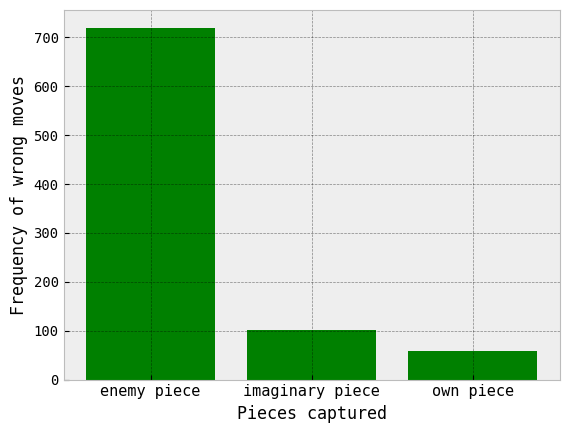

In [355]:
a = dict(Counter(pieces_captured))
ind = np.argsort(list(a.values()))[::-1]

bars = list(a.keys())
heights = np.array(list(a.values()))[ind]

plt.bar(bars, heights, color = 'g')
plt.grid(alpha = 0.45, linestyle = "--", color = 'black')

plt.xlabel("Pieces captured")
plt.ylabel("Frequency of wrong moves")
plt.xticks(fontsize =11)
plt.show()

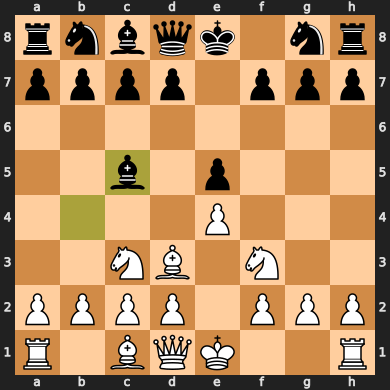

'imaginary piece'

In [336]:
identify_nature_of_captured_piece(moves, "Bxg3")

In [391]:
def f(x):

    moves_scores = literal_eval(x)

    l = []

    for score in moves_scores:
        if score != 'None' and score != None:
            if score != -100:
                l.append(score)
            else:
                l.append(0)
    return np.mean(np.array(l))


In [392]:
x = df['moves score (centipawns)'].apply(f)

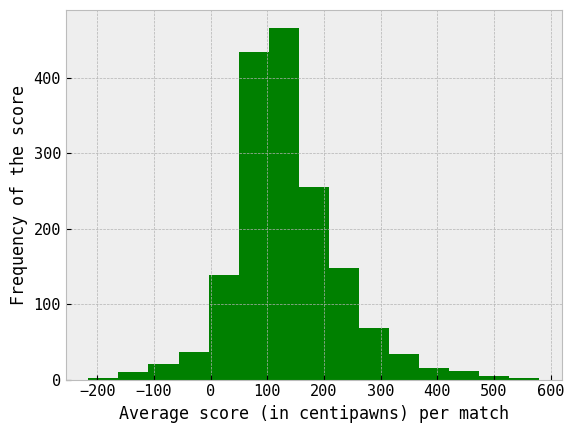

In [411]:
fig, ax = plt.subplots()
ax.hist(x, bins = 15, color = 'green')
ax.set_xlabel("Average score (in centipawns) per match")
ax.set_ylabel("Frequency of the score")
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
plt.show()

In [402]:
y = df['moves place in top 10'].apply(f)

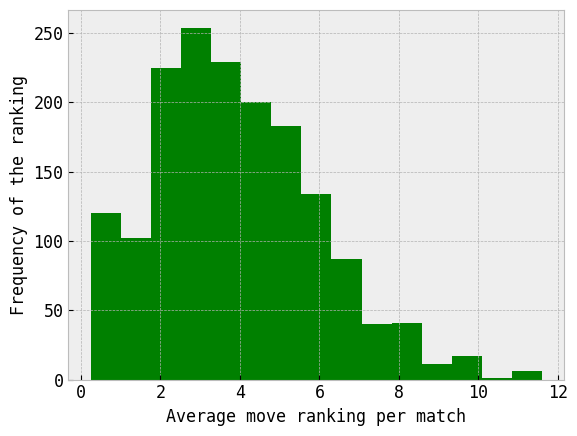

In [412]:
fig, ax = plt.subplots()
ax.hist(y, bins = 15, color = 'green')
ax.set_xlabel("Average move ranking per match")
ax.set_ylabel("Frequency of the ranking")
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.show()

In [153]:
board = display_game(df.at[315, "game"])
# capture its own piece
chess.svg.board(
    board, 
    lastmove = chess.Move.from_uci("e3d3"),arrows=[chess.svg.Arrow(chess.E3, chess.D3, color="#FF0000")],
size=500)
board_to_save = chess.svg.board(
    board, 
    lastmove = chess.Move.from_uci("e3d3"),arrows=[chess.svg.Arrow(chess.E3, chess.D3, color="#FF0000")],
size=500)
outputfile = open('D:/NLP_group/pictures/capture_own_piece.svg', "w")
outputfile.write(board_to_save)
outputfile.close()

In [187]:
# skips piece
board = display_game(df.at[69, "game"])
chess.svg.board(
    board, 
    lastmove = chess.Move.from_uci("e3d3"),arrows=[chess.svg.Arrow(chess.E2, chess.E8, color="#FF0000")],
size=500)
board_to_save = chess.svg.board(
    board, 
    lastmove = chess.Move.from_uci("e2e8"),arrows=[chess.svg.Arrow(chess.E2, chess.E8, color="#FF0000")],
size=500)
outputfile = open('D:/NLP_group/pictures/capture_enemy_king.svg', "w")
outputfile.write(board_to_save)
outputfile.close()

In [194]:
# moves a piece completely wrong
board = display_game(df.at[618, "game"])
board_to_save = chess.svg.board(
    board, 
    lastmove = chess.Move.from_uci("a7e4"),arrows=[chess.svg.Arrow(chess.A7, chess.E4, color="#FF0000")],
size=500)
outputfile = open('D:/NLP_group/pictures/moves_completely_wrong.svg', "w")
outputfile.write(board_to_save)
outputfile.close()

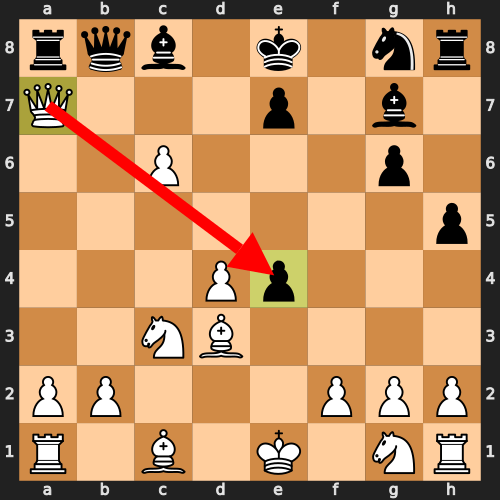

In [195]:
board_to_save

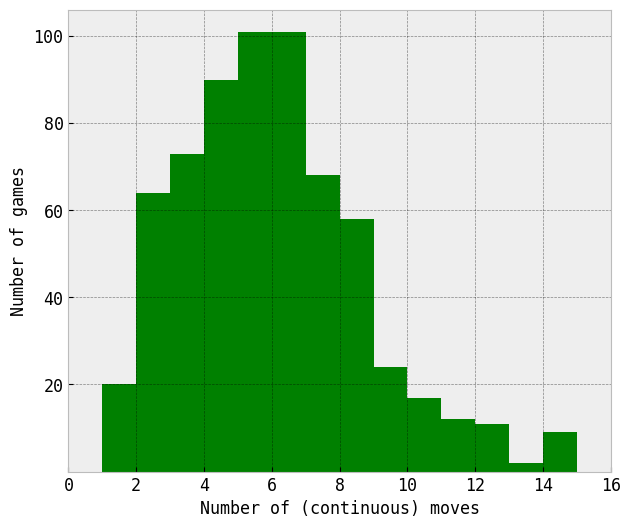

In [185]:
fig, ax = plt.subplots(figsize = (7,6))

ax.hist(df['number of moves'], color = 'green', density = False, bins = 14)
#df['number of moves'].plot(kind = "kde", color = 'red')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_xlim([0, 16])
ax.set_ylim(bottom = 0.001)

ax.grid(alpha = 0.45, linestyle = "--", color = 'black')
plt.xlabel("Number of (continuous) moves")
plt.ylabel("Number of games")
plt.show()

In [8]:
def find_mistakes(moves):
    
    board = chess.Board()

    moves_list = moves.split()
    final_moves = [x.split('.')[-1] for x in moves_list]

    for m in final_moves:
        board.push_san(m)

    return board.piece_at(chess.parse_square("c5"))

In [9]:
def moves_piece_incorrectly(moves, faulty_move):
    """
    Identify if the faulty move is due to an attempt to incorrectly move a piece.
    Whenever this is the case, identify the wrongly moved piece.

    The following notations are used to encode pieces:

    pawn -- 1
    knight -- 2
    bishop -- 3
    rook -- 4
    queen -- 5
    king -- 6

    Parameters
    ----------
    moves : string
        sequence of moves encoding the board configuration at the moment when
        ChatGPT performed an illegal move
    faulty_move : string
        the illegal move selected by ChatGPT that determined the game to break
    """

    # the type of a piece is the first character of a move in the Standard Algebraic Notation
    # note that a pawn is not signaled by a specific letter but we can check that since the symbol
    # the symbol for any other piece is uppercase
    piece_symbol = faulty_move[0]

    if piece_symbol.isupper():
        piece = chess.Piece.from_symbol(piece_symbol)

    else:
        # when no symbol is present, the piece must be a pawn
        piece = chess.Piece.from_symbol('P')

    return piece



In [10]:
def get_board(moves):

    board = chess.Board()

    moves_list = moves.split()
    final_moves = [x.split('.')[-1] for x in moves_list]

    for m in final_moves:
        board.push_san(m)

    return board

In [11]:
def capture_imaginary_piece(board, faulty_move):

    if faulty_move[1] != 'x':

        return False

    else:

        # this is the square where ChatGPT decided to move the piece
        attacked_square = faulty_move[2:4]

        # trasform into a chess Square object
        sq = chess.parse_square(attacked_square)

        # check if there is a piece on this square
        piece_on_target_square = board.piece_type_at(sq)